In [49]:
pip install ucimlrepo


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [50]:
from network.dataset import Dataset
from network.dataloader import DataLoader
from network.model import Model
from network.linear import LinearLayer
from network.relu import ReLU
from network.mse import MSELoss
from network.adam import AdamWOptimizer

In [51]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
monk_s_problems = fetch_ucirepo(id=70) 
  
# data (as pandas dataframes) 
X = monk_s_problems.data.features 
y = monk_s_problems.data.targets 
  
# metadata 
print(monk_s_problems.metadata) 
  
# variable information 
print(monk_s_problems.variables) 


{'uci_id': 70, 'name': "MONK's Problems", 'repository_url': 'https://archive.ics.uci.edu/dataset/70/monk+s+problems', 'data_url': 'https://archive.ics.uci.edu/static/public/70/data.csv', 'abstract': 'A set of three artificial domains over the same attribute space; Used to test a wide range of induction algorithms', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 432, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C5R30R', 'creators': ['J. Wnek'], 'intro_paper': {'ID': 400, 'type': 'NATIVE', 'title': "The MONK''s Problems-A Performance Comparison of Different Learning Algorithms, CMU-CS-91-197, Sch", 'authors': 'S. Thrun', 'venue': 'Carnegie Mellon University', 'year': 1991, 'journal': None, 'DOI': None, 'URL': 'ht

In [52]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

monk = fetch_ucirepo(id=70)

X_df = monk.data.features      # columns: a1 ... a6
y_df = monk.data.targets       # column: class
print(X_df.head())
print(y_df.head())

   a1  a2  a3  a4  a5  a6
0   1   1   1   1   1   1
1   1   1   1   1   1   2
2   1   1   1   1   2   1
3   1   1   1   1   2   2
4   1   1   1   1   3   1
   class
0      1
1      1
2      1
3      1
4      1


In [53]:
# One-hot encode all feature columns (a1..a6)
X_oh = pd.get_dummies(X_df)

# Convert to NumPy (float32 for your NN)
X = X_oh.astype(np.float32).to_numpy()

# Targets: 0/1 as float32 column vector (N, 1)
y = y_df["class"].astype(np.float32).to_numpy().reshape(-1, 1)

print("X shape:", X.shape)   # should be (N, 17)
print("y shape:", y.shape)   # (N, 1)

X shape: (432, 6)
y shape: (432, 1)


In [54]:
n_total = X.shape[0]
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)

X_train, y_train = X[:n_train],               y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val],  y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:],         y[n_train+n_val:]

In [55]:
from network.dataset import Dataset
from network.dataloader import DataLoader

train_dataset = Dataset(X_train, y_train)
val_dataset   = Dataset(X_val,   y_val)
test_dataset  = Dataset(X_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [56]:
input_dim = X_train.shape[1]   # should be 17
print("input_dim:", input_dim)

model = Model(
    LinearLayer(input_dim, 16),
    ReLU(),
    LinearLayer(16, 8),
    ReLU(),
    LinearLayer(8, 1),
)

loss_fn = MSELoss()
optimizer = AdamWOptimizer(model, learning_rate=0.001, weight_decay=0.01)

input_dim: 6


In [57]:
num_epochs = 100
train_loss_history = []
val_loss_history   = []
val_acc_history    = []

for epoch in range(num_epochs):
    # ----- Training -----
    train_losses = []
    for x_batch, y_batch in train_loader:
        y_pred = model.forward(x_batch)
        loss = loss_fn.forward(y_pred, y_batch)

        grad = loss_fn.backward()
        model.backward(grad)
        optimizer.step()

        train_losses.append(loss)

    # ----- Validation -----
    val_losses = []
    correct = 0
    total = 0

    for x_batch, y_batch in val_loader:
        y_pred = model.forward(x_batch)
        loss = loss_fn.forward(y_pred, y_batch)
        val_losses.append(loss)

        # threshold 0.5 for class 0/1
        preds = (y_pred > 0.5).astype(np.float32)
        correct += (preds == y_batch).sum()
        total   += y_batch.size

    mean_train = float(np.mean(train_losses))
    mean_val   = float(np.mean(val_losses))
    val_acc    = float(correct / total)

    train_loss_history.append(mean_train)
    val_loss_history.append(mean_val)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1:03d} | "
          f"Train Loss: {mean_train:.4f} | "
          f"Val Loss: {mean_val:.4f} | "
          f"Val Acc: {val_acc:.4f}")

Epoch 001 | Train Loss: 6.4333 | Val Loss: 6.0572 | Val Acc: 0.3023
Epoch 002 | Train Loss: 3.1331 | Val Loss: 3.0041 | Val Acc: 0.3023
Epoch 003 | Train Loss: 1.4520 | Val Loss: 1.4255 | Val Acc: 0.3023
Epoch 004 | Train Loss: 0.6613 | Val Loss: 0.6680 | Val Acc: 0.3953
Epoch 005 | Train Loss: 0.3831 | Val Loss: 0.3738 | Val Acc: 0.6047
Epoch 006 | Train Loss: 0.3367 | Val Loss: 0.2817 | Val Acc: 0.6744
Epoch 007 | Train Loss: 0.3281 | Val Loss: 0.2686 | Val Acc: 0.6744
Epoch 008 | Train Loss: 0.3149 | Val Loss: 0.2957 | Val Acc: 0.6279
Epoch 009 | Train Loss: 0.3019 | Val Loss: 0.3094 | Val Acc: 0.6279
Epoch 010 | Train Loss: 0.2956 | Val Loss: 0.3101 | Val Acc: 0.6279
Epoch 011 | Train Loss: 0.2864 | Val Loss: 0.3052 | Val Acc: 0.6279
Epoch 012 | Train Loss: 0.2833 | Val Loss: 0.3046 | Val Acc: 0.6047
Epoch 013 | Train Loss: 0.2757 | Val Loss: 0.2948 | Val Acc: 0.6279
Epoch 014 | Train Loss: 0.2716 | Val Loss: 0.2909 | Val Acc: 0.6279
Epoch 015 | Train Loss: 0.2667 | Val Loss: 0.298

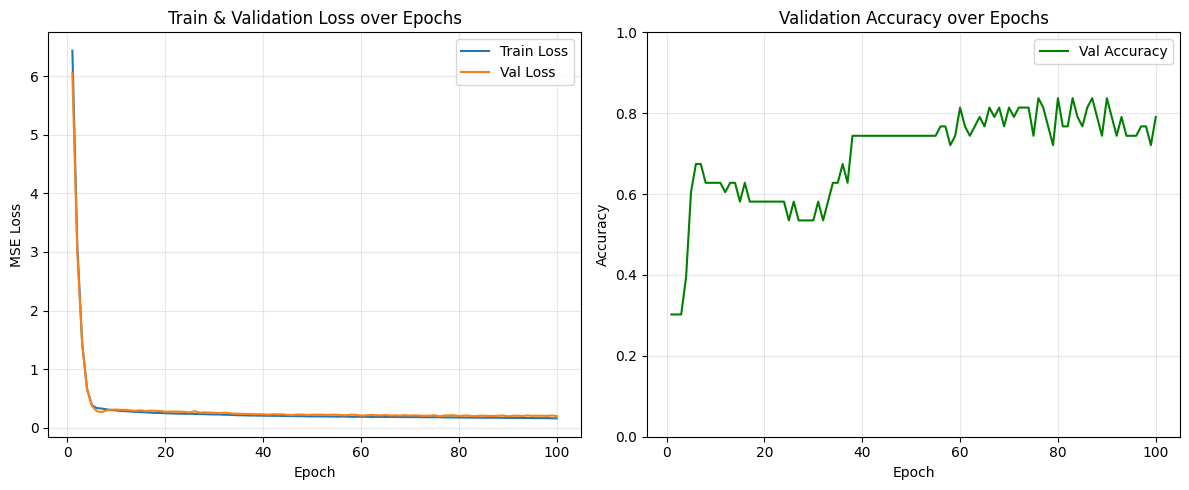

In [58]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 5))

# ------------------ LOSS ------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train & Validation Loss over Epochs")
plt.legend()
plt.grid(alpha=0.3)

# ------------------ ACCURACY ------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc_history, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.ylim(0.0, 1.0)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()